In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib as mpl
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [3]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [4]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
m_cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

sig_threshes = [0.05, 0.01, 0.001]
sig_annots = ['*', '**', '***']

In [8]:
def read_cons_table():
    df = pd.read_csv(human_mouse_sect_cons, sep='\t')
    print(len(df.index))
    df['sector_conserved'] = df.sector_human == df.sector_mouse
    df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
    gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()
    return df

13494
             gene_id gene_name  gene_len  n_overlapping_alu   Gene stable ID  \
558  ENSG00000049540       ELN     42219                 30  ENSG00000049540   

    sector_human  sector_conserved  alus_per_kb  
558     splicing             False     0.710581  
tes sector conserved vs. non conserved alus_per_kb stat: 1427967.0, pval: 0.4221417257440311
simple sector conserved vs. non conserved alus_per_kb stat: 328622.0, pval: 0.030717557076045635
mixed sector conserved vs. non conserved alus_per_kb stat: 4199200.5, pval: 0.0012247390882155961
splicing sector conserved vs. non conserved alus_per_kb stat: 112492.0, pval: 0.007025951766442666
tss sector conserved vs. non conserved alus_per_kb stat: 218778.5, pval: 0.0005916171877556662


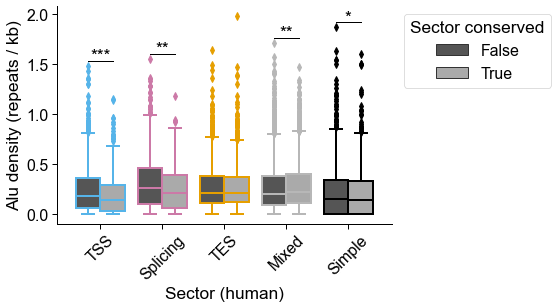

<Figure size 432x288 with 0 Axes>

In [14]:
df = read_cons_table()

temp = pd.read_csv('alu_gtf_intersect.tsv', sep='\t')
temp['overlaps_alu'] = temp.Overlap==temp.alu_len
temp['gene_len'] = (temp.Start-temp.End).abs()
temp2 = temp[['gene_id', 'gene_name', 'gene_len', 'overlaps_alu']].groupby(['gene_id', 'gene_name', 'gene_len']).sum().reset_index().rename({'overlaps_alu': 'n_overlapping_alu'}, axis=1)

# limit just to the orthologs
# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
temp2 = temp2.loc[temp2.gene_id.isin(all_gids)]
temp2 = temp2.merge(df[['Gene stable ID', 'sector_human', 'sector_conserved']],
                    how='left',
                    left_on='gene_id',
                    right_on='Gene stable ID')
temp2['alus_per_kb'] = ((temp2.n_overlapping_alu)*1000)/temp2.gene_len
print(temp2.loc[temp2.gene_name=='ELN'])

df = temp2.copy(deep=True)
c_dict, order = get_sector_colors()
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6,4))

shade_dict, _ = get_shade_colors('#000000', ['dummy', False, True])
col = 'alus_per_kb'
# ax = sns.boxplot(df, y='log_mean_intron_len', x='sect_disp', order=order, palette=c_dict, fill=False)
ax = sns.boxplot(df, x='sector_human',
                 hue='sector_conserved',
                 y=col, order=order,
                 linewidth=2,
                 palette=shade_dict)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
col_label = col.split('_')[0].capitalize()
if col_label != 'Mean':
    col_label+='.'
ylabel = f'Alu density (repeats / kb)'
xlabel = 'Sector (human)'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
# _ = ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
ax.tick_params(axis="x", rotation=45)
labels = [item.get_text() for item in ax.get_xticklabels()]
for i,l in enumerate(labels):
    if l in ['tss', 'tes']:
        labels[i] = l.upper()
    else:
        labels[i] = l.capitalize()
ax.set_xticklabels(labels)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1),
           title='Sector conserved')

pvals = {}
for sector in df.sector_human.unique().tolist():
    temp = df.loc[df.sector_human==sector]
    x = temp.loc[temp.sector_conserved==True, col].dropna().tolist()
    y = temp.loc[temp.sector_conserved==False, col].dropna().tolist()
    stat, pval = st.mannwhitneyu(x,y)
    print(f'{sector} sector conserved vs. non conserved {col} stat: {stat}, pval: {pval}')
    pvals[sector] = pval

box_patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):

    j = int(i/2)
    sector = order[j]
    sect_color = c_dict[sector]


    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    # col = patch.get_facecolor()
    patch.set_edgecolor(sect_color)
    # patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(sect_color)
        line.set_mfc(sect_color)  # facecolor of fliers
        line.set_mec(sect_color)  # edgecolor of fliers

    # sig annotations
    if i%len(df.sector_conserved.unique()) == 1:

        if pvals[sector] <= max(sig_threshes):
            for annot, thresh in zip(sig_annots, sig_threshes):
                if pvals[sector] <= thresh:
                    sig_annot = annot

            x1 = j-0.2
            x2 = j+0.2
            y = df.loc[df.sector_human==sector, col].max() + 0.05
            h = 0.05
            color = 'k'

            plt.plot([x1, x2], [y, y], lw=1, c=color)
            plt.text((x1+x2)*.5, y-0.025, sig_annot, ha='center', va='bottom', color=color)


# save figure
fname = f'figures/alu_density_vs_sector_cons_{col}.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')
plt.show()
plt.clf()
